In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import hilbert, butter, filtfilt, spectrogram
from scipy.ndimage import gaussian_filter, gaussian_filter1d
import mne
from statsmodels.tsa.stattools import acf
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.mplot3d import Axes3D

In [31]:
# Load EEG data
eeg_time = np.load('/Users/novak/Documents/UTSW/erfan/eeg_time.npy')
eeg_signal = np.load('/Users/novak/Documents/UTSW/erfan/eeg_signal.npy')

# Determine sampling frequency from time array
fs = 1 / np.mean(np.diff(eeg_time))
print(f"Sampling frequency: {fs:.2f} Hz")
print(f"Signal shape: {eeg_signal.shape}")
print(f"Duration: {eeg_time[-1] - eeg_time[0]:.2f} seconds")

Sampling frequency: 400.00 Hz
Signal shape: (1440000,)
Duration: 3600.00 seconds


In [ ]:
# ============== PREPROCESSING ==============
# NOTE: EEG vs LFP differences:
# - LFP (intracranial): high SNR, useful up to 200+ Hz, can see ripples/gamma
# - EEG (scalp): lower SNR, useful mostly < 50 Hz (high freq = muscle artifact)
# 
# For EEG: use narrower bandpass (e.g., 0.5-40 Hz or 1-30 Hz)
# For LFP: can use wider bandpass (e.g., 0.5-200 Hz)

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """Bandpass filter using Butterworth filter"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def lowpass_filter(data, cutoff, fs, order=4):
    """Lowpass filter using Butterworth filter"""
    nyquist = 0.5 * fs
    b, a = butter(order, cutoff / nyquist, btype='low')
    return filtfilt(b, a, data)

def notch_filter(data, notch_freq, fs, Q=30):
    """Notch filter to remove power line noise (60 Hz in US, 50 Hz in EU)"""
    b, a = signal.iirnotch(notch_freq, Q, fs)
    return filtfilt(b, a, data)

def preprocess_eeg(x, fs, low=0.5, high=40.0, notch_freqs=(60.0,), target_fs=500):
    """
    Preprocess EEG signal (scalp recording):
    1. Notch filter (60 Hz power line, optionally 120 Hz harmonic)
    2. Bandpass filter (0.5-40 Hz typical for EEG)
    3. Z-score normalization
    4. Optional downsampling
    
    For LFP, use wider band: low=0.5, high=200
    """
    y = x.astype(float).copy()
    
    # Step 1: Notch filter for power line noise
    for f0 in notch_freqs:
        if f0 < fs / 2:  # Only if below Nyquist
            b, a = signal.iirnotch(f0, Q=30, fs=fs)
            y = signal.filtfilt(b, a, y)
    
    # Step 2: Bandpass filter (SOS form for stability)
    wn = [low/(fs/2), high/(fs/2)]
    sos = signal.butter(4, wn, btype='bandpass', output='sos')
    y = signal.sosfiltfilt(sos, y)
    
    # Step 3: Z-score normalization (optional but helps AR)
    y = (y - np.mean(y)) / (np.std(y) + 1e-12)
    
    # Step 4: Downsample if needed
    fs_out = fs
    if fs > target_fs:
        r = int(np.floor(fs / target_fs))
        y = signal.decimate(y, r, ftype='iir', zero_phase=True).astype(float)
        fs_out = fs / r
    
    return y, fs_out

def preprocess_lfp(x, fs, low=0.5, high=200.0, notch_freqs=(50.0, 60.0), target_fs=500):
    """
    Preprocess LFP signal (intracranial recording):
    - Wider bandpass (0.5-200 Hz) to capture gamma/ripples
    """
    return preprocess_eeg(x, fs, low=low, high=high, notch_freqs=notch_freqs, target_fs=target_fs)

# Select channel if multi-channel
if eeg_signal.ndim == 2:
    raw_signal = eeg_signal[:, 0]  # Take first channel
else:
    raw_signal = eeg_signal.ravel()

# ============== CHOOSE YOUR PREPROCESSING ==============
# For EEG (scalp): narrower band, focus on 0.5-40 Hz 
# For LFP: wider band, can go up to 200 Hz

# EEG settings (RECOMMENDED for scalp EEG):
xs, fs_proc = preprocess_eeg(raw_signal, fs, low=0.5, high=40.0, notch_freqs=(60.0,), target_fs=500)

# # LFP settings (if this were intracranial data):
# xs, fs_proc = preprocess_lfp(raw_signal, fs, low=0.5, high=200.0, notch_freqs=(60.0,), target_fs=500)

time_proc = np.arange(len(xs)) / fs_proc

print(f"Processed sampling rate: {fs_proc:.2f} Hz")
print(f"Processed signal length: {len(xs)} samples")
print(f"Using EEG preprocessing: bandpass 0.5-40 Hz, 60 Hz notch")

Processed sampling rate: 400.00 Hz
Processed signal length: 1440000 samples
Using EEG preprocessing: bandpass 0.5-40 Hz, 60 Hz notch


In [ ]:
# # ============== NO PREPROCESSING - USE RAW DATA ==============
# # Select channel if multi-channel
# if eeg_signal.ndim == 2:
#     raw_signal = eeg_signal[:, 0]  # Take first channel
# else:
#     raw_signal = eeg_signal.ravel()

# # Use raw signal directly (just z-score normalize for AR stability)
# xs = (raw_signal - np.mean(raw_signal)) / (np.std(raw_signal) + 1e-12)

# # Keep original sampling rate
# fs_proc = fs

# # Create time array
# time_proc = np.arange(len(xs)) / fs_proc

# print(f"Sampling rate: {fs_proc:.2f} Hz")
# print(f"Signal length: {len(xs)} samples")
# print(f"Using raw data (z-score normalized only)")


Sampling rate: 400.00 Hz
Signal length: 1440000 samples
Using raw data (z-score normalized only)


In [33]:
# ============== AR MODEL HELPER FUNCTIONS ==============
def lag_matrix(x, p):
    """Create lag matrix for AR model"""
    N = len(x)
    y = x[p:].copy()
    X = np.zeros((N-p, p))
    for i in range(p):
        X[:, i] = x[p-1-i : N-1-i]
    return X, y

def ols_with_intercept(X, y):
    """OLS regression with intercept"""
    D = np.column_stack([np.ones(len(X)), X])
    w = np.linalg.lstsq(D, y, rcond=None)[0]
    return w  # [c, a1..ap]

def predict_from_params(X, w):
    """Predict using fitted parameters"""
    D = np.column_stack([np.ones(len(X)), X])
    return D @ w

def metrics(y_true, y_pred):
    """Compute MSE, MAE, and correlation"""
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    yt = y_true - np.mean(y_true)
    yp = y_pred - np.mean(y_pred)
    r = (yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12)
    return mse, mae, r

def acf(sig, nlags=60):
    s = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac0 = ac[0] if ac[0] != 0 else 1.0
    ac = ac / ac0
    return ac[:nlags+1]

def aic_bic(y, yhat, k):
    """Compute AIC and BIC"""
    n = len(y)
    rss = np.sum((y - yhat)**2)
    sigma2 = rss / max(n, 1)
    aic = n*np.log(sigma2 + 1e-12) + 2*k
    bic = n*np.log(sigma2 + 1e-12) + k*np.log(max(n, 2))
    return aic, bic

def hybrid_ar(series, w, p, start_idx, n_steps, refresh_every=1):
    """
    Controllable-step AR rollout
    refresh_every=1: classic 1-step prediction
    refresh_every=k: k-step ahead prediction
    """
    preds = []
    hist = series[start_idx - p : start_idx].tolist()
    for t in range(n_steps):
        if (t % max(int(refresh_every), 1)) == 0:
            abs_idx = start_idx + t
            hist = series[abs_idx - p : abs_idx].tolist()
        xhat = w[0] + np.dot(w[1:], list(reversed(hist)))
        preds.append(xhat)
        hist.pop(0)
        hist.append(xhat)
    return np.array(preds)

def embed3(s, tau):
    """Create 3D delay embedding"""
    return np.column_stack([s[2*tau:], s[tau:-tau], s[:-2*tau]])

print("AR helper functions loaded.")

AR helper functions loaded.


In [34]:
# ============== GLOBAL PLOT STYLE ==============
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "lines.linewidth": 1.8,
    "lines.markersize": 5,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

color_main = "black"
color_alt = "darkred"

def prettify(ax, title=None, xlabel=None, ylabel=None, add_legend=False):
    """Unified styling for axes"""
    if title: ax.set_title(title, pad=10)
    if xlabel: ax.set_xlabel(xlabel, labelpad=5)
    if ylabel: ax.set_ylabel(ylabel, labelpad=5)
    ax.grid(alpha=0.0, linestyle="--", linewidth=0.7)
    if add_legend: 
        ax.legend(frameon=False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(1.0)

print("Plot style configured.")

Plot style configured.


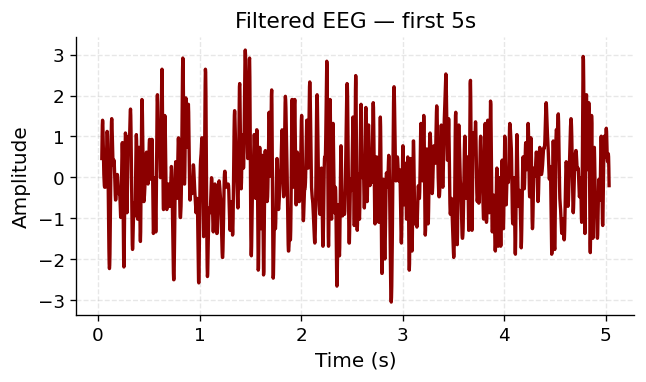

<Figure size 768x576 with 0 Axes>

In [40]:
# ============== PLOT (a): Filtered Time Series ==============
snippet_sec = 5  # seconds to display
start_idx = 15  # start index to avoid edge effects
N_snip = int(snippet_sec * fs_proc)
t_snip = time_proc[start_idx:start_idx+N_snip]
x_snip = xs[start_idx:start_idx+N_snip]

# Data type label (change based on your data)
DATA_TYPE = "EEG"  # Options: "EEG" (scalp) or "LFP" (intracranial)

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(t_snip, x_snip, lw=2.0, color=color_alt)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title(f"Filtered {DATA_TYPE} — first {snippet_sec}s")
ax.grid(True, ls='--', alpha=0.3)
ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)
plt.show()
plt.tight_layout()

In [43]:
raw_signal.shape

(1440000,)

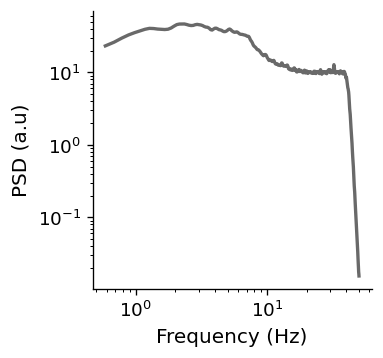

<Figure size 768x576 with 0 Axes>

In [41]:
# ============== PLOT (c): PSD ==============
# PSD frequency range depends on data type:
#   EEG (scalp): 0.5-50 Hz (higher is mostly artifact)
#   LFP (intracranial): 0.5-200 Hz (can see gamma/ripples)

PSD_FMAX = 50.0 if DATA_TYPE == "EEG" else 200.0
# SHADE_BAND = (0.5, 40) if DATA_TYPE == "EEG" else (1, 20)  # Frequency band to highlight

# Compute PSD using Welch method
psd, freqs = mne.time_frequency.psd_array_welch(
    raw_signal[None, :],
    sfreq=fs,
    fmin=0.5, fmax=PSD_FMAX,
    n_fft=4096,
    n_overlap=2048,
    average='mean',
    verbose=False
)
psd = psd[0]

# Smooth PSD
psd_smooth = gaussian_filter1d(psd, sigma=1)

# Plot PSD
fig, ax = plt.subplots(figsize=(3, 3))
ax.loglog(freqs, psd_smooth, 'dimgray', lw=2)

# Add shaded region for frequency band of interest
# freq_mask = (freqs >= SHADE_BAND[0]) & (freqs <= SHADE_BAND[1])
# ax.fill_between(freqs[freq_mask], psd_smooth[freq_mask], alpha=0.3, color='gray')

ax.set_xlabel("Frequency (Hz)")

ax.set_ylabel("PSD (a.u)")
plt.show()

ax.set_title(f"{DATA_TYPE} PSD")
plt.tight_layout()

ax.grid(True, ls="--", alpha=0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [10]:
# ============== AR MODEL FITTING ==============
# Sweep AR order p to find best
p_list = list(range(2, 7))
mse_te_list, aic_list, bic_list = [], [], []
params_by_p = {}
splits = {}

train_frac = 0.1  # 10% for training

for p in p_list:
    X, y = lag_matrix(xs, p)
    N = len(y)
    ntr = int(train_frac * N)
    X_tr, y_tr = X[:ntr], y[:ntr]
    X_te, y_te = X[ntr:], y[ntr:]
    w = ols_with_intercept(X_tr, y_tr)
    yhat_tr = predict_from_params(X_tr, w)
    yhat_te = predict_from_params(X_te, w)
    mse_te, _, _ = metrics(y_te, yhat_te)
    aic, bic = aic_bic(y_tr, yhat_tr, k=p+1)
    mse_te_list.append(mse_te)
    aic_list.append(aic)
    bic_list.append(bic)
    params_by_p[p] = w
    splits[p] = (ntr, y, yhat_tr, yhat_te)

best_p_by_mse = p_list[int(np.argmin(mse_te_list))]
best_p_by_bic = p_list[int(np.argmin(bic_list))]

# Override: Use elbow method — p=3 is where MSE plateaus
best_p_by_mse = 3
best_p_by_bic = 3  

print(f"Best p by elbow method: p={best_p_by_mse}")
print(f"Best p by BIC (training fit): p={best_p_by_bic}")

Best p by elbow method: p=3
Best p by BIC (training fit): p=6


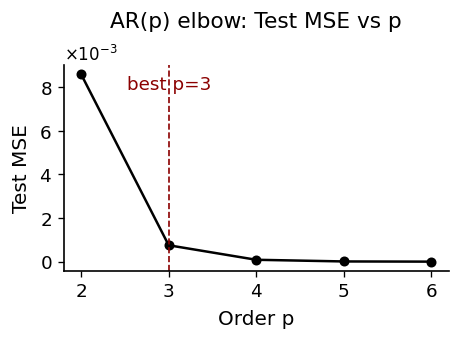

In [11]:
# ============== PLOT (d): AR(p) Elbow - MSE vs p ==============
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(p_list, mse_te_list, marker='o', color=color_main, lw=1.5, ms=5)
ax.axvline(best_p_by_mse, linestyle='--', color=color_alt, linewidth=1)
ax.text(best_p_by_mse, ax.get_ylim()[1]*0.95, f"best p={best_p_by_mse}",
        ha='center', va='top', color=color_alt, fontsize=11)

sf = ScalarFormatter(useMathText=True)
sf.set_powerlimits((-3, 3))
ax.yaxis.set_major_formatter(sf)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
ax.yaxis.get_offset_text().set_size(10)
prettify(ax, title="AR(p) elbow: Test MSE vs p", xlabel="Order p", ylabel="Test MSE")
plt.tight_layout()
plt.show()

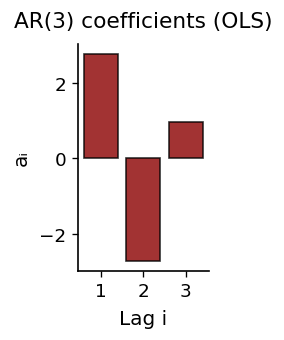

In [12]:
# ============== PLOT (e): AR Coefficients Bar Plot ==============
p_use = best_p_by_mse  # or best_p_by_bic
w = params_by_p[p_use]

fig, ax = plt.subplots(figsize=(2, 3))
bars = ax.bar(np.arange(1, p_use+1), w[1:], color=color_alt, edgecolor=color_main, alpha=0.8)
prettify(ax, title=f"AR({p_use}) coefficients (OLS)", xlabel="Lag i", ylabel="aᵢ")
plt.tight_layout()
plt.show()

In [25]:
# ============== AR PREDICTION SETUP ==============
REFRESH_EVERY = 5  # Prediction horizon (1=1-step, larger=multi-step)


p_use = best_p_by_bic
# Prepare indices for chosen p
X, y = lag_matrix(xs, p_use)
ntr, y_all, yhat_tr, yhat_te = splits[p_use]
N_te = len(y) - ntr
t0 = p_use + ntr  # absolute index where test begins

true_test = xs[t0 : t0 + N_te]

# Generate predictions with controllable refresh
yhat_ctrl = hybrid_ar(xs, w, p_use, start_idx=t0, n_steps=N_te, refresh_every=REFRESH_EVERY)

print(f"Using AR({p_use}) with refresh_every={REFRESH_EVERY}")

Using AR(3) with refresh_every=5


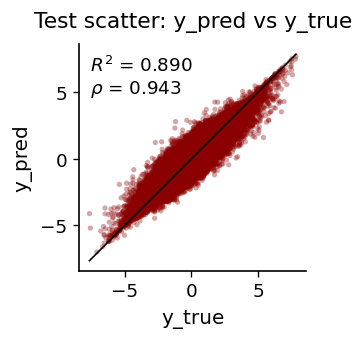

In [26]:
# ============== PLOT (b): y_pred vs y_true Scatter ==============
y_true = y[ntr:]
y_pred = yhat_ctrl

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(y_true, y_pred, c=color_alt, alpha=0.35, s=10, edgecolors="none")

# Plot identity line
vmin = min(np.min(y_true), np.min(y_pred))
vmax = max(np.max(y_true), np.max(y_pred))
ax.plot([vmin, vmax], [vmin, vmax], color=color_main, lw=1)

# Compute R² and correlation
yt = y_true - np.mean(y_true)
yp = y_pred - np.mean(y_pred)
corr = float((yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12))
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2 = 1 - ss_res / (ss_tot + 1e-12)

ax.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\n$\\rho$ = {corr:.3f}",
        transform=ax.transAxes, ha='left', va='top', fontsize=11,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round"))
ax.set_aspect('equal', adjustable='box')
prettify(ax, title=f"Test scatter: y_pred vs y_true", xlabel="y_true", ylabel="y_pred")
plt.tight_layout()
plt.show()

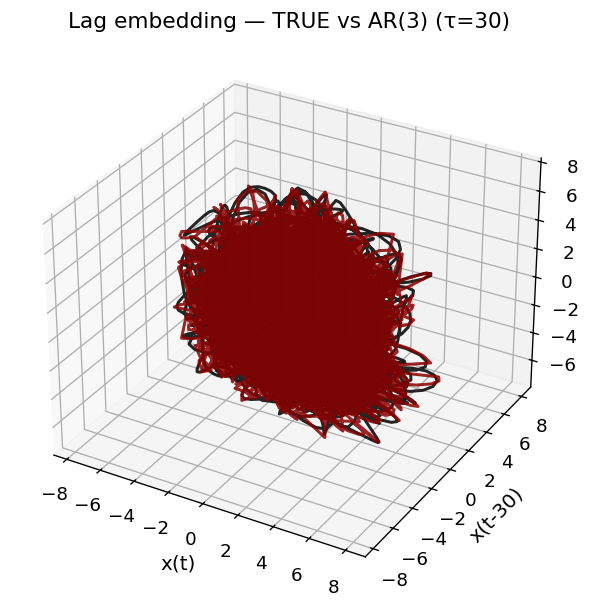

<Figure size 768x576 with 0 Axes>

In [28]:
# ============== PLOT (f): 3D State Space / Lag Embedding ==============
# Embedding delay (tau) should be ~1/4 of dominant oscillation period
# EEG alpha (10 Hz) at 500 Hz sampling: tau ~ 500/(10*4) = 12-15
# LFP theta (6 Hz) at 500 Hz sampling: tau ~ 500/(6*4) = 20-25
# LFP with higher freq content: tau ~ 5-15

tau = 30   # Adjust based on dominant frequency

# Variance-match for fair geometric overlay
hy = yhat_ctrl - np.mean(yhat_ctrl)
hy = hy * (np.std(true_test) / (np.std(hy) + 1e-12)) + np.mean(true_test)

X3_true = embed3(true_test, tau)
X3_pred = embed3(hy, tau)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot true trajectory
ax.plot(X3_true[:,0], X3_true[:,1], X3_true[:,2], 
        label="True", color="black", alpha=0.85)

# Plot AR prediction trajectory
ax.plot(X3_pred[:,0], X3_pred[:,1], X3_pred[:,2],
        label=f"AR({p_use}) Prediction", color="darkred", alpha=0.85)

ax.set_title(f"Lag embedding — TRUE vs AR({p_use}) (τ={tau})")
ax.set_xlabel("x(t)")

ax.set_ylabel(f"x(t-{tau})")
plt.show()

ax.set_zlabel(f"x(t-{2*tau})")
plt.tight_layout()
ax.legend(frameon=False)